In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [66]:
# Load data into a pandas DataFrame
crops = pd.read_csv('Crop_recommendation.csv')

# Extract features containing only the temperature, humidity, ph, month and label columns
features = ['temperature', 'humidity', 'soil moisture','rainfall']

labels = crops['label']

X = crops[features]
y = crops['harvest time']

print(X)

      temperature   humidity  soil moisture  rainfall
0       20.879744  82.002744       0.791620     121.0
1       21.770462  80.319644       0.570048     121.0
2       23.004459  82.320763       0.517319     121.0
3       26.491096  80.158363       0.788417     121.0
4       20.130175  81.604873       0.645932     121.0
...           ...        ...            ...       ...
1295    23.874845  86.792613       0.302342     102.0
1296    23.928879  88.071123       0.462125     102.0
1297    24.814412  81.686889       0.479884     102.0
1298    24.447439  82.286484       0.835364     102.0
1299    26.574217  73.819949       0.641753     102.0

[1300 rows x 4 columns]


In [67]:
# Convert categorical features to numerical values and normalize the data
label_encoder = LabelEncoder()
# X['month'] = label_encoder.fit_transform(X['month'])
# X['label'] = label_encoder.fit_transform(X['label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [68]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Create a  KFold object for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV with KFold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)




Best hyperparameters:  {'max_depth': 7, 'max_features': None, 'n_estimators': 300}
Best cross-validation score:  -57.97981712287431


Test Root Mean Square Error: 7.65

C:\Users\wan_n\AppData\Local\Temp\ipykernel_106100\3709626397.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(unique_labels))


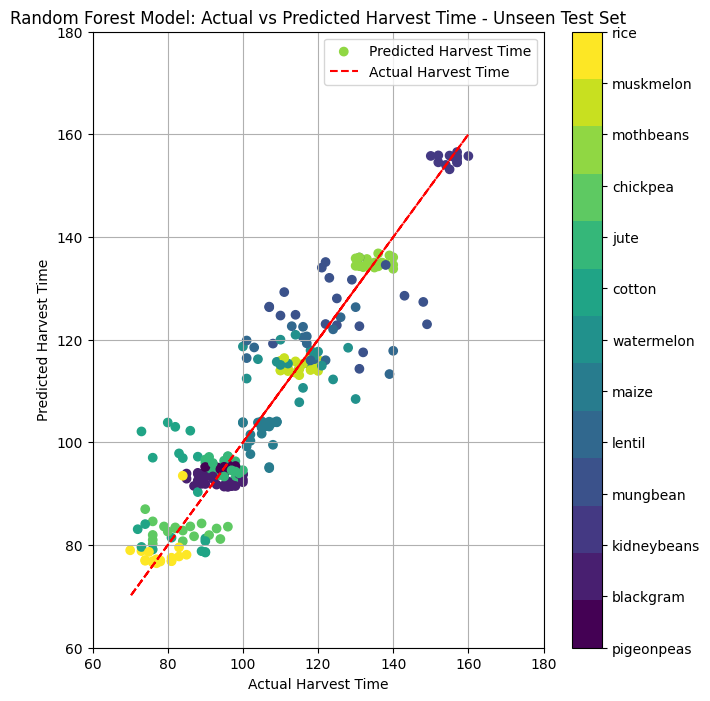

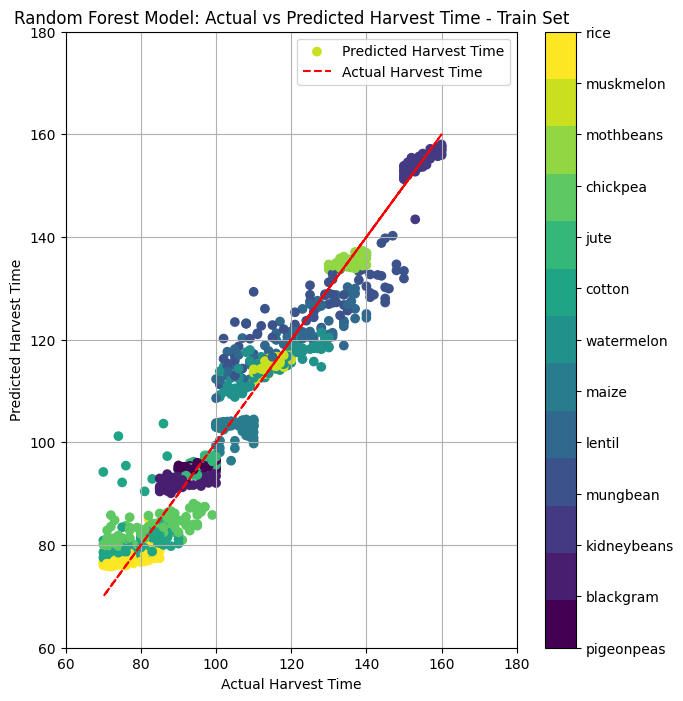

In [69]:
# Make predictions on the test data using the best model
test_pred = grid_search.best_estimator_.predict(X_test)

# Add the predicted harvest time to your test set
X_test['predicted_harvest'] = test_pred

# Convert the numerical labels back to original crop names
X_test['label'] = labels.loc[X_test.index]

# Convert 'label' to numeric for plotting
X_test['label_numeric'] = X_test['label'].astype('category').cat.codes

# Get the unique crop types
unique_labels = X_test['label'].unique()

# Create a color map with a different color for each unique crop type
cmap = plt.cm.get_cmap('viridis', len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]
crop_type_colors = dict(zip(unique_labels, colors))

# Create the scatter plot with a colormap for the test set
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
scatter = plt.scatter(y_test, test_pred, c=X_test['label_numeric'], cmap=cmap, label='Predicted Harvest Time')
cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
plt.plot(y_test, y_test, color='red', linestyle='--', label='Actual Harvest Time')
plt.xlabel('Actual Harvest Time')
plt.ylabel('Predicted Harvest Time')
plt.title('Random Forest Model: Actual vs Predicted Harvest Time - Unseen Test Set')
plt.ylim(60, 180)
plt.xlim(60, 180)
plt.legend()
plt.grid(True)

# Create the scatter plot with a colormap for the train set
train_pred = grid_search.best_estimator_.predict(X_train)

X_train['predicted_harvest'] = train_pred

X_train['label'] = labels.loc[X_train.index]

# Convert 'label' to numeric for plotting
X_train['label_numeric'] = X_train['label'].astype('category').cat.codes

plt.figure(figsize=(16, 8))
plt.subplot(1,2,2)
scatter = plt.scatter(y_train, train_pred, c=X_train['label_numeric'], cmap=cmap, label='Predicted Harvest Time')
cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
plt.plot(y_train, y_train, color='red', linestyle='--', label='Actual Harvest Time')
plt.xlabel('Actual Harvest Time')
plt.ylabel('Predicted Harvest Time')
plt.title('Random Forest Model: Actual vs Predicted Harvest Time - Train Set')
plt.ylim(60, 180)
plt.xlim(60, 180)
plt.legend()
plt.grid(True)

# Calculate the RMSE on the test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test Root Mean Square Error: {test_rmse:.2f}")

Index(['temperature', 'humidity', 'soil moisture', 'rainfall'], dtype='object')
Shape of crop_features.columns:  (4,)
Shape of feature_importances:  (4,)


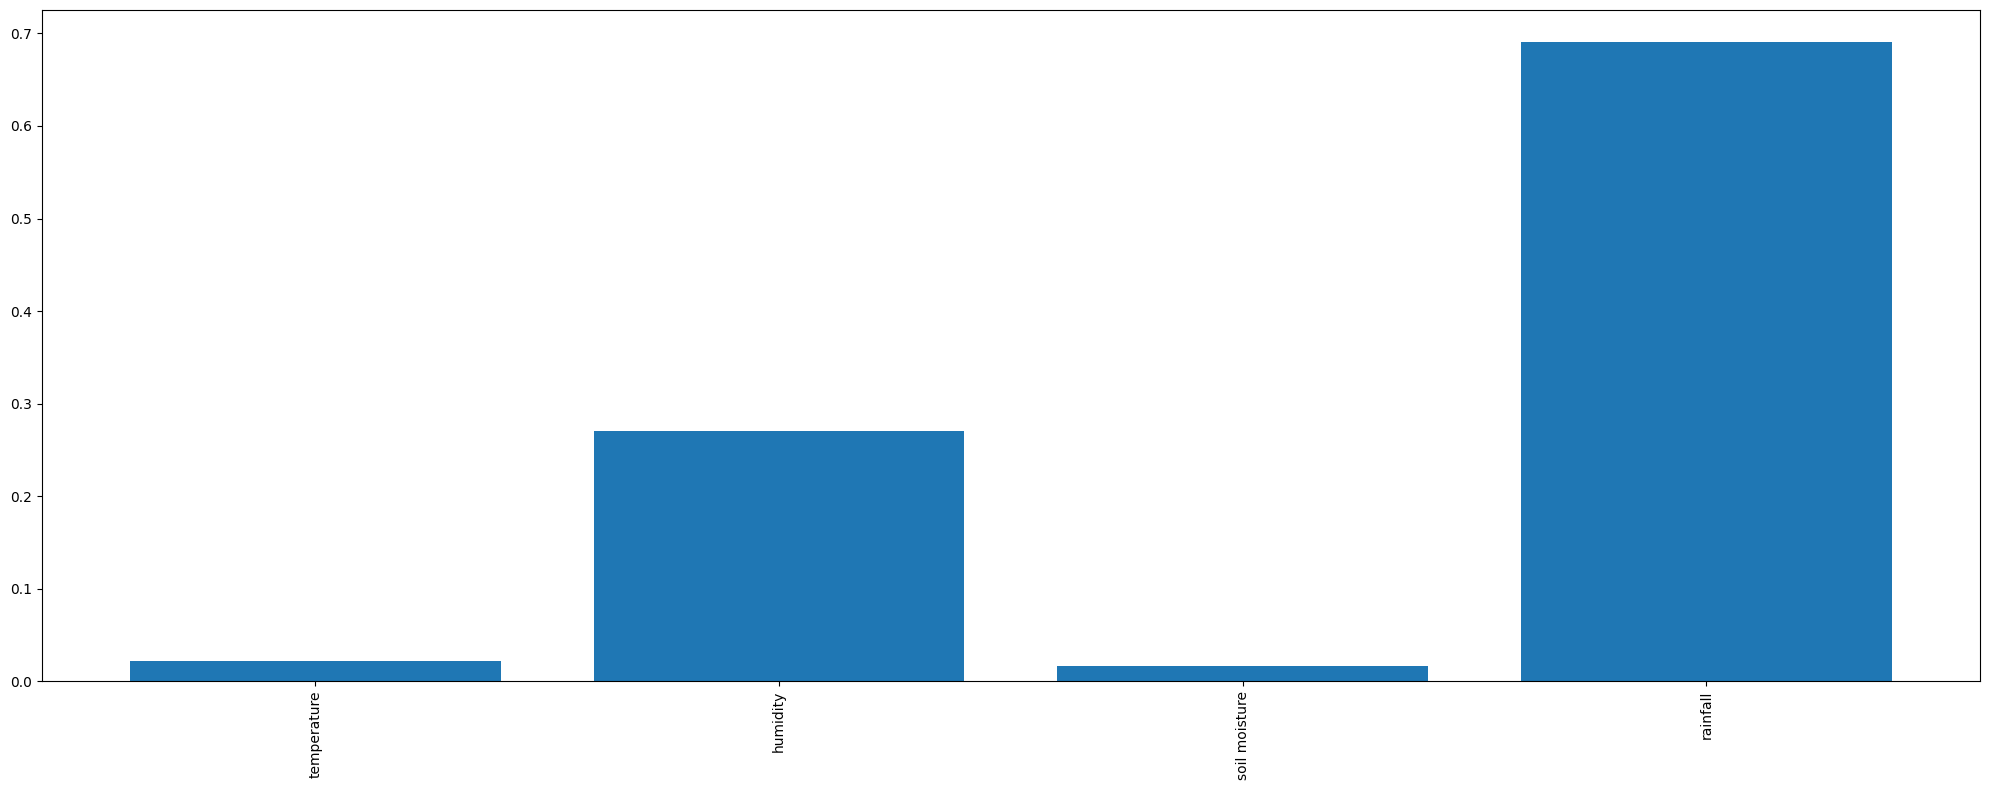

In [70]:
crop_features = crops.drop(['ph', 'water availability', 'month', 'label','harvest time'], axis=1)
feature_importances = grid_search.best_estimator_.feature_importances_
print(crop_features.columns)
print("Shape of crop_features.columns: ", crop_features.columns.shape)
print("Shape of feature_importances: ", feature_importances.shape)
plt.figure(figsize=(20, 8))
plt.bar(crop_features.columns, feature_importances)
plt.xticks(rotation=90)
plt.tight_layout()

In [136]:
classifier_model = RandomForestClassifier(random_state=42)

# Prepare the training data for month model
X_month = crops[['temperature', 'humidity', 'soil moisture', 'rainfall']]
y_month = label_encoder.fit_transform(crops['month'])

# Split features and labels for crop label prediction
X_label = crops[['temperature', 'humidity', 'soil moisture', 'rainfall']]
y_label = label_encoder.fit_transform(crops['label'])

X_train_month, X_test_month, y_train_month, y_test_month = train_test_split(X_month, y_month, test_size=0.2, random_state=42)
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

# Train the month model
classifier_model.fit(X_train_month, y_train_month)

# Train the label model
classifier_model.fit(X_train_label, y_train_label)

# Make predictions on the test data using the best model
y_pred_month = classifier_model.predict(X_test_month)
y_pred_label = classifier_model.predict(X_test_label)

C:\Users\wan_n\AppData\Local\Temp\ipykernel_106100\964262682.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test_label, y_pred_label, cmap='viridis', label='Predicted Crop Label')


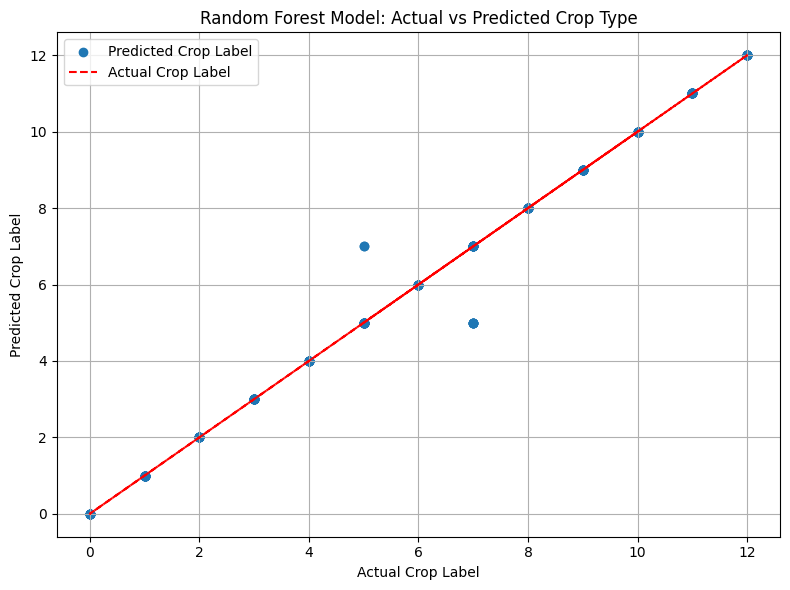

In [137]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 1, 1)
plt.scatter(y_test_label, y_pred_label, cmap='viridis', label='Predicted Crop Label')
plt.plot(y_test_label, y_test_label, color='red', linestyle='--', label='Actual Crop Label')
plt.xlabel('Actual Crop Label')
plt.ylabel('Predicted Crop Label')
plt.title('Random Forest Model: Actual vs Predicted Crop Type')

plt.tight_layout()
plt.legend()
plt.grid(True)

In [95]:
def predict_harvest_time(temperature, humidity, soil_moisture, rainfall):
    try: 
        # Check if the input values are valid
        if not isinstance(temperature, (int, float)) or temperature < 0:
            raise ValueError("Temperature must be a positive number.")
        if not isinstance(humidity, (int, float)) or humidity < 0 or humidity > 100:
            raise ValueError("Humidity must be a number between 0 and 100.")
        if not isinstance(soil_moisture, (int, float)) or soil_moisture < 0 or soil_moisture > 1:
            raise ValueError("Soil moisture must be a number between 0 and 1.")
        if not isinstance(rainfall, (int, float)) or rainfall < 0:
            raise ValueError("Rainfall must be a positive number.")

        # Create a DataFrame with user inputs
        user_input = pd.DataFrame({
            'temperature': [temperature],
            'humidity': [humidity],
            'soil moisture': [soil_moisture],
            'rainfall': [rainfall],
        })
         
        # Make the prediction
        predicted_harvest_time = grid_search.best_estimator_.predict(user_input)
        
        # Make the prediction for month using the month model
        month_probs = classifier_model.predict_proba(user_input)
        predicted_month_idx = np.argmax(month_probs)
        predicted_month = label_encoder.inverse_transform([predicted_month_idx])[0]

        # Make the prediction for label using the label model
        label_probs = classifier_model.predict_proba(user_input)
        predicted_label_idx = np.argmax(label_probs)
        predicted_label = label_encoder.inverse_transform([predicted_label_idx])[0]
        
        return predicted_harvest_time[0], predicted_month, predicted_label
    
    except ValueError as e:
        print(f"Error: {e}")
        return None, None, None

In [ ]:
temperature = float(input("Enter temperature: "))
humidity = float(input("Enter humidity: "))
soil_moisture = float(input("Enter soil moisture: "))
rainfall = float(input("Enter rainfall: "))

predicted_harvest_time, predicted_month, predicted_label = predict_harvest_time(temperature, humidity, soil_moisture, rainfall)

if predicted_harvest_time is not None:
    print(f"Predicted harvest time: {predicted_harvest_time:.2f} days")
    print(f"Predicted month: {predicted_month}")
    print(f"Predicted crop type: {predicted_label}")

In [ ]:
# # Convert string labels to numerical values (encoding)
# unique_labels = np.unique(y_test)
# label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
# y_test_numeric = np.array([label_mapping[label] for label in y_test])
# y_pred_numeric = np.array([label_mapping[label] for label in y_pred])

# # Create color map with different color for each unique crop type
# cmap = plt.cm.get_cmap('viridis', len(unique_labels))
# colors = [cmap(i) for i in range(len(unique_labels))]
# crop_type_colors = dict(zip(unique_labels, colors))

# # Create scatter plot for temperature vs. humidity
# fig, ax = plt.subplots(figsize=(10, 6))
# scatter = ax.scatter(X_test['temperature'], X_test['humidity'], c=y_pred_numeric, cmap=cmap)
# ax.set_xlabel('Temperature')
# ax.set_ylabel('Humidity')
# ax.set_title('Temperature vs. Humidity (Predicted Crop Types)')
# cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
# cbar.ax.set_yticklabels(unique_labels)
# plt.show()

# # Create scatter plot for humidity vs. pH
# fig, ax = plt.subplots(figsize=(10, 6))
# scatter = ax.scatter(X_test['humidity'], X_test['ph'], c=y_pred_numeric, cmap=cmap)
# ax.set_xlabel('Humidity')
# ax.set_ylabel('pH')
# ax.set_title('Humidity vs. pH (Predicted Crop Types)')
# cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
# cbar.ax.set_yticklabels(unique_labels)
# plt.show()

# # Create scatter plot for temperature vs. pH
# fig, ax = plt.subplots(figsize=(10, 6))
# scatter = ax.scatter(X_test['temperature'], X_test['ph'], c=y_pred_numeric, cmap=cmap)
# ax.set_xlabel('Temperature')
# ax.set_ylabel('pH')
# ax.set_title('Temperature vs. pH (Predicted Crop Types)')
# cbar = plt.colorbar(scatter, ticks=range(len(unique_labels)))
# cbar.ax.set_yticklabels(unique_labels)
# plt.show()